# Деревья решений. Классификация грибов.

In [47]:
import pandas as pd
import numpy as np
import sklearn.tree as st
import sklearn.externals.six as sx
import sklearn.cross_validation  as cv
import sklearn.metrics as sm
import matplotlib.pyplot as pl

import pydot

%pylab inline

Populating the interactive namespace from numpy and matplotlib


[Лепиота](https://www.wikiwand.com/ru/%D0%9B%D0%B5%D0%BF%D0%B8%D0%BE%D1%82%D0%B0), или чешуйница (лат. Lepiota) — род грибов семейства Шампиньоновые (Agaricaceae). Некоторые виды съедобны, некоторые ядовиты. Цель этого задания - построить модель, позволяющую определить съедобность гриба по внешнему виду.

In [48]:
from IPython.core.display import HTML
HTML('<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/28/Lepiota_magnispora_39264.jpg/1024px-Lepiota_magnispora_39264.jpg" width=400 height=300/>') 

Загружаем данные [Agaricus Lepiota](https://archive.ics.uci.edu/ml/datasets/Mushroom) из UCI Machine Learning Repository.

In [49]:
column_names=[
    'classification', 
    'cap_shape', 
    'cap_surface', 
    'cap_color', 
    'bruises', 
    'odor', 
    'gill_attachment', 
    'gill_spacing', 
    'gill_size', 
    'gill_color', 
    'stalk_shape', 
    'stalk_root', 
    'stalk_surface_above_ring', 
    'stalk_surface_below_ring', 
    'stalk_color_above_ring', 
    'stalk_color_below_ring', 
    'veil_type', 
    'veil_color', 
    'ring_number', 
    'ring_type', 
    'spore_print_color',           
    'population', 
    'habitat'
]

mushrooms_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data",
    header=None,
    names=column_names,
    converters=dict((name, lambda c: ord(c)) for name in column_names)
)

X = mushrooms_df.values[:, 1:]
# 1 is edible, 0 is poisonous
Y = (mushrooms_df.values[:, 0] == 101).astype(int)

print "Successfully loaded %dx%d X data set for %d objects" % (X.shape[0], X.shape[1], Y.shape[0])

Successfully loaded 8124x22 X data set for 8124 objects


Вспомогательный класс, позволяющий показывать PDF файлы в notebook.

In [50]:
class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

### Построение дерева решений

Разделяем данные на тренировочную и тестовую выборки. Для построения модели используем уже реализованный [алгоритм](http://scikit-learn.org/stable/modules/tree.html) из `sklearn`. Постройте 2 модели с разными impurity: gini и entropy.

Предсказываем класс для тестовой части. Требуется посчитать precision и recall класса съедобных для обоих моделей. Какая impurity работает лучше?

In [64]:
X_train, X_test, Y_train, Y_test = cv.train_test_split(X, Y, test_size=0.5, random_state=42)

clf = st.DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)
# TODO: Compare precision and recall for "edible" class for two impurity measures

Нарисуем полученное дерево. Какие правила соответствуют ядовитым, а какие съедобным грибам? Какие признаки лучше всего разделяют выборку?

In [65]:
dot_data = sx.StringIO() 
st.export_graphviz(clf, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("tree.pdf")

PDF("tree.pdf", size=(960, 320))

### Глубина дерева и переобучение

Для того чтобы исследовать, насколько качество модели зависит от глубины дерева, постройте графики зависимости ошибки классификации на тренировочной и тестовой подвыборках от глубины дерева. Какая глубина является оптимальной?

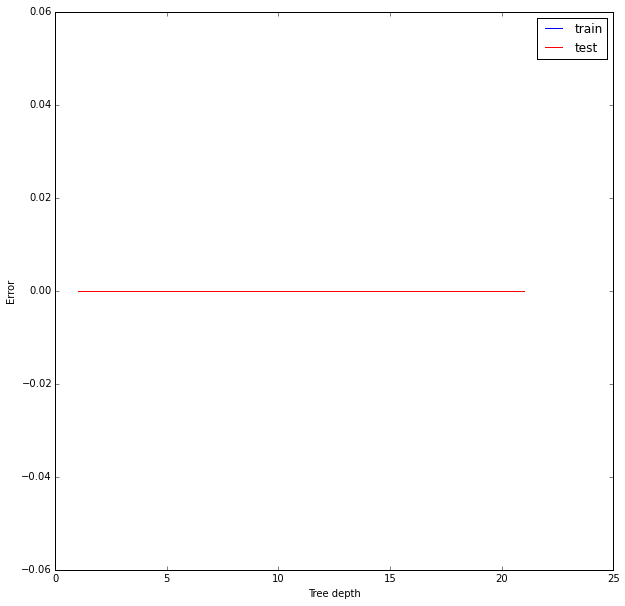

In [73]:
ks = np.arange(1, 22)
train_err = np.zeros(ks.shape[0])
test_err = np.zeros(ks.shape[0])

# TODO: Compute train_err and test_err

pl.figure(figsize=(10, 10))
pl.plot(ks, train_err, 'b', label="train")
pl.plot(ks, test_err, 'r', label="test")
pl.xlabel("Tree depth")
pl.ylabel("Error")
pl.legend()
pl.show()

### Чувствительность дерева решений к шуму

Исследуем, насколько небольшие изменения в данных влияют на конфигурацию полученного дерева решений. С маленькой вероятностью изменим значение каждого признака каждого объекта на значение этого же признака следующего объекта. Постройте дерево решений для новой "зашумленной" выборки. Отличается ли оно от дерева, построенного для исходной? Повторите эксперимент несколько раз.

In [117]:
p = 1e-2
max_depth = 5

X_noisy_train = np.copy(X_train)

# TODO: Add noise to X_noisy_train

# Train and save noiseless tree
clf = st.DecisionTreeClassifier(max_depth=max_depth)
clf.fit(X_train, Y_train)

dot_data = sx.StringIO() 
st.export_graphviz(clf, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("noiseless_tree.pdf")

# Train and save noisy tree
clf = st.DecisionTreeClassifier(max_depth=max_depth)
clf.fit(X_noisy_train, Y_train)

dot_data = sx.StringIO() 
st.export_graphviz(clf, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("noisy_tree.pdf")

True

### Классификация грибов

Подберите параметры классификатора так, чтобы получить наилучший результат классификации среди своих коллег. Для оценки качества модели используйте точность (accuracy) и 10-fold кросс-валидацию. Победитель сможет сам выбрать понравившийся вариант в пятом ДЗ, при условии успешного выполнения всех пунктов этого туториала. При одинаковых результатах побеждает первый.

In [135]:
clf = st.DecisionTreeClassifier()
scores = np.ones(10)
# TODO: Implement computing 10-fold CV accuracy scores
print "CV Accuracy: Mean=%.3f, Std=%.3f" % (scores.mean(), scores.std())

CV Accuracy: Mean=1.000, Std=0.000


In [136]:
HTML('<img src="http://aromi-group.com/wp-content/uploads/2013/11/cream-of-mushroom.jpg" width=400 height=300/>') 

Спасибо за внимание!